<a href="https://colab.research.google.com/github/srinayani123/Mentalhealth_reddit_classification/blob/main/Model_finetuning/classification/mentalhealth_reddit_distillbert_uncased.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#MODEL FINETUNING

#DISTILL BERT CLASSIFICATION

In [ ]:
!pip install transformers datasets evaluate -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.7 MB/s eta 0:00:00


In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import Dataset
from sklearn.model_selection import train_test_split
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer
)
import evaluate

In [ ]:
# 1. Load and clean your data
from google.colab import files
import io
import pandas as pd

uploaded = files.upload()
filename = list(uploaded.keys())[0]  # get uploaded file name
df = pd.read_csv(io.BytesIO(uploaded[filename]))

df["text"] = df["title"].fillna("") + " " + df["text"].fillna("")
df["label"] = df["target"]
df = df[["text", "label"]]

Saving data_to_be_cleansed.csv to data_to_be_cleansed.csv


In [ ]:

# Train-test split
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_function(example):
    return tokenizer(example["text"], truncation=True)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/4765 [00:00<?, ? examples/s]

Map:   0%|          | 0/1192 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/tmp/ipython-input-5-3907065670.py:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mankali-srinayani (mankali-srinayani-other) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
500,0.826400


/tmp/ipython-input-5-3907065670.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=["Total Parameters", "Trainable Parameters"], y=[total_params, trainable_params], palette="plasma")


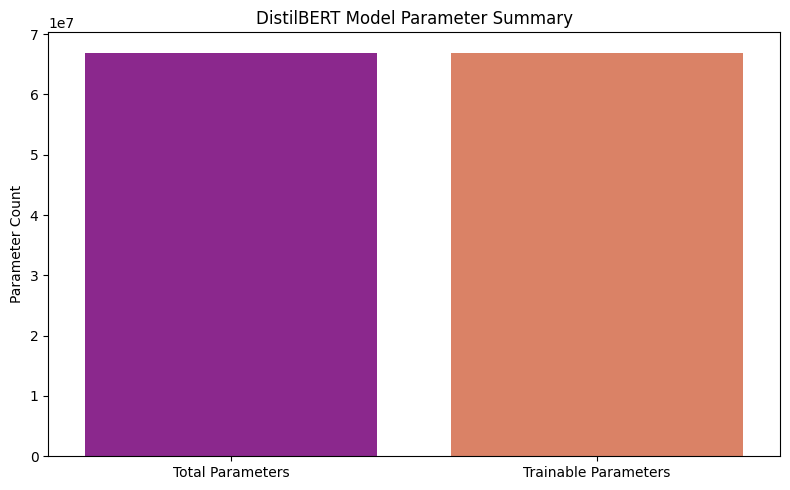

In [ ]:

# Model
model_class = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=5)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return accuracy.compute(predictions=predictions, references=labels)


# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir='./logs',
)

# Trainer
trainer = Trainer(
    model=model_class,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

total_params = sum(p.numel() for p in model_class.parameters())
trainable_params = sum(p.numel() for p in model_class.parameters() if p.requires_grad)

plt.figure(figsize=(8, 5))
sns.barplot(x=["Total Parameters", "Trainable Parameters"], y=[total_params, trainable_params], palette="plasma")
plt.title("DistilBERT Model Parameter Summary")
plt.ylabel("Parameter Count")
plt.tight_layout()
plt.show()


#DISTILL BERT EVALUATION-

The classification evaluation of the fine-tuned DistilBERT model on the mental health text dataset yielded strong performance, with an overall accuracy of 82.3% and balanced precision (82.4%), recall (82.3%), and F1 score (82.3%). The per-class breakdown reveals that the model performs best on classes 0 and 2, achieving high F1 scores of 0.8731 and 0.8442 respectively, indicating reliable identification of those mental health categories. Class 1 showed relatively lower precision and F1, suggesting room for improvement in distinguishing its patterns. The consistency between macro and weighted averages confirms robust performance across all categories, despite potential class imbalance. These results suggest that while the model is effective overall, targeted refinement for specific classes (especially class 1) and incorporation of domain-specific models or techniques like cost-sensitive learning may further enhance predictive accuracy and reliability.

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding
import torch
import numpy as np

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
test_dataloader = DataLoader(
    test_dataset.remove_columns(["text", "__index_level_0__"]) if "__index_level_0__" in test_dataset.column_names else test_dataset.remove_columns(["text"]),
    batch_size=16,
    collate_fn=data_collator
)

# Move model to GPU/CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_class.to(device)
model_class.eval()

# Evaluate in batches
all_preds = []
all_labels = []

for batch in test_dataloader:
    labels = batch["labels"].to(device)
    inputs = {k: v.to(device) for k, v in batch.items() if k != "labels"}

    with torch.no_grad():
        outputs = model_class(**inputs)
    logits = outputs.logits
    preds = torch.argmax(logits, axis=1)

    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

# Evaluation metrics
accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="weighted")

print("\n📊 Evaluation Report:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")

print("\n📋 Classification Report (per class):")
print(classification_report(all_labels, all_preds, digits=4))



📊 Evaluation Report:
Accuracy : 0.8138
Precision: 0.8140
Recall   : 0.8138
F1 Score : 0.8136

📋 Classification Report (per class):
              precision    recall  f1-score   support

           0     0.8692    0.8729    0.8710       236
           1     0.7672    0.7386    0.7526       241
           2     0.8578    0.8397    0.8486       237
           3     0.8008    0.7875    0.7941       240
           4     0.7765    0.8319    0.8032       238

    accuracy                         0.8138      1192
   macro avg     0.8143    0.8141    0.8139      1192
weighted avg     0.8140    0.8138    0.8136      1192



In [ ]:
true_labels = all_labels
pred_labels = all_preds


The plot shows class-wise evaluation metrics for the task of mental health text classification into five emotional or psychological states. Class 0, likely representing clear high-risk or crisis expressions, is predicted with the highest reliability, with precision and F1 scores above 0.87—indicating the model handles urgent, explicit distress cues well. Class 2, potentially representing anxiety or agitation, also shows strong scores, especially in precision, suggesting it’s well recognized when present. However, Class 1, which may correspond to more ambiguous or moderate emotional states like sadness or withdrawal, records the lowest performance across all metrics (~0.75), pointing to overlap or confusion with adjacent classes. This insight is critical since subtle states are harder to capture and may require more nuanced feature engineering or targeted data augmentation. Classes 3 and 4 (possibly representing emotional numbness or recovery phases) show balanced performance around 0.81–0.83. This breakdown helps identify that while the model performs well on extreme or distinct expressions, it needs further tuning to handle more nuanced mental health signals.

In [ ]:
import plotly.express as px
import pandas as pd
from sklearn.metrics import classification_report


true_labels = [int(label) for label in true_labels]
pred_labels = [int(label) for label in pred_labels]

# Generate classification report
report = classification_report(true_labels, pred_labels, output_dict=True, zero_division=0)
report_df = pd.DataFrame(report).transpose().reset_index()
report_df = report_df[report_df["index"].isin(["0", "1", "2", "3", "4"])]
report_df.rename(columns={"index": "Class", "precision": "Precision", "recall": "Recall", "f1-score": "F1 Score"}, inplace=True)
report_df = report_df[["Class", "Precision", "Recall", "F1 Score"]]

# Melt for Plotly
melted_df = report_df.melt(id_vars="Class", var_name="Metric", value_name="Score")

# Plot
fig = px.bar(
    melted_df,
    x="Metric",
    y="Score",
    color="Class",
    barmode="group",
    facet_col="Class",
    text="Score",
    title="📊 Evaluation Metrics Per Class",
    color_discrete_sequence=px.colors.sequential.Plasma,
    template="plotly_dark",
    height=500
)

fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')
fig.update_layout(
    paper_bgcolor='black',
    plot_bgcolor='black',
    font=dict(color='white'),
    title_font=dict(size=20),
    uniformtext_minsize=8,
    uniformtext_mode='hide',
    xaxis_title="Evaluation Metric",
    yaxis_title="Score",
    showlegend=False
)

fig.show()


The confusion matrix highlights how the model performs in assigning correct emotional state labels in the mental health classification task. Class 0 is classified most accurately, with 203 correct predictions out of 236, and relatively few misclassifications spread across other classes. However, Class 1 and Class 3 exhibit notable confusion—especially Class 1, which is often predicted as Class 3 (24 times) and Class 4 (14 times), indicating possible semantic overlap in text associated with sadness, stress, or low motivation. Similarly, Class 3 is frequently misclassified as Class 1 (26 times), suggesting these categories may share overlapping expressions of emotional struggle or withdrawal. These off-diagonal values suggest the model struggles to cleanly differentiate more moderate or complex emotional tones. Such observations support the need for either more fine-tuned data or better representation learning, possibly via domain-adapted language models or multi-task setups that jointly capture emotion intensity and type.

In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px
from sklearn.metrics import confusion_matrix


# Compute confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
cm_df = pd.DataFrame(cm, index=[f"True {i}" for i in range(cm.shape[0])],
                        columns=[f"Pred {i}" for i in range(cm.shape[1])])

# Plot confusion matrix
fig_cm = px.imshow(
    cm_df,
    text_auto=True,
    color_continuous_scale="Plasma",
    title="📊 Confusion Matrix",
    aspect="auto"
)

fig_cm.update_layout(
    template="plotly_dark",
    paper_bgcolor='black',
    plot_bgcolor='black',
    font=dict(color='white'),
    title_font=dict(size=20),
    xaxis_title="Predicted Label",
    yaxis_title="True Label"
)

fig_cm.show()


The ROC curve illustrates strong discriminative performance across all five classes in the mental health classification task. Class 0 achieves the highest AUC (0.92), showing the model is highly confident in identifying this class with minimal false positives. Class 2 and Class 4 also score well with AUCs of 0.90, indicating consistent separation between true and false cases. Meanwhile, Class 1 has the lowest AUC at 0.85, suggesting the model finds it harder to distinguish this class—likely due to overlap in textual features with adjacent emotional states. Despite this, all classes show curves that rise sharply towards the top-left corner, signaling that the classifier is reliably effective, even in a nuanced domain like mental health text



In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import plotly.graph_objects as go

# Convert labels to one-hot format
n_classes = len(np.unique(true_labels))
y_true_bin = label_binarize(true_labels, classes=list(range(n_classes)))
y_pred_bin = label_binarize(pred_labels, classes=list(range(n_classes)))

# Compute ROC curves
fig_roc = go.Figure()

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
    roc_auc = auc(fpr, tpr)

    fig_roc.add_trace(go.Scatter(
        x=fpr, y=tpr,
        mode='lines',
        name=f'Class {i} (AUC={roc_auc:.2f})'
    ))

# Add random baseline
fig_roc.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', line=dict(dash='dash'), name='Random'))

# Layout
fig_roc.update_layout(
    title="📈 ROC Curves (One-vs-Rest)",
    xaxis_title="False Positive Rate",
    yaxis_title="True Positive Rate",
    template="plotly_dark",
    paper_bgcolor='black',
    plot_bgcolor='black',
    font=dict(color='white'),
    title_font=dict(size=20),
    height=500
)

fig_roc.show()


In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Zero diagonal to focus only on errors
cm_no_diag = cm.copy()
np.fill_diagonal(cm_no_diag, 0)

# Convert to DataFrame
cm_df = pd.DataFrame(cm_no_diag, index=[f"True {i}" for i in range(cm.shape[0])],
                                    columns=[f"Pred {i}" for i in range(cm.shape[1])])

# Plot error-only heatmap
fig_misclass = px.imshow(
    cm_df,
    text_auto=True,
    color_continuous_scale="Reds",
    title="🚨 Misclassification Heatmap",
    labels=dict(x="Predicted", y="Actual", color="Count")
)

fig_misclass.update_layout(
    template="plotly_dark",
    paper_bgcolor='black',
    plot_bgcolor='black',
    font=dict(color='white'),
    title_font=dict(size=20)
)

fig_misclass.show()



The misclassification heatmap highlights that Class 1 texts are often misclassified as Class 3 and Class 4, with 24 and 14 such instances respectively. This suggests that expressions associated with moderate distress (Class 1) share surface-level cues with more intense emotional states. Class 3 is particularly prone to being mistaken for Class 1, with 26 misclassifications, indicating overlap in language used to describe mental strain and hopelessness. Class 4 also sees confusion with Class 0 and Class 1, pointing to ambiguity in less explicit expressions of distress. These patterns suggest the model struggles most with adjacent severity levels, particularly between Classes 1, 3, and 4.

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import plotly.graph_objects as go

# Convert to one-hot if needed
n_classes = len(np.unique(true_labels))
y_true_bin = label_binarize(true_labels, classes=list(range(n_classes)))
y_pred_bin = label_binarize(pred_labels, classes=list(range(n_classes)))

fig_pr = go.Figure()

for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_pred_bin[:, i])
    ap = average_precision_score(y_true_bin[:, i], y_pred_bin[:, i])

    fig_pr.add_trace(go.Scatter(
        x=recall, y=precision,
        mode='lines',
        name=f'Class {i} (AP={ap:.2f})'
    ))

# Layout
fig_pr.update_layout(
    title="📉 Precision-Recall Curves (One-vs-Rest)",
    xaxis_title="Recall",
    yaxis_title="Precision",
    template="plotly_dark",
    paper_bgcolor='black',
    plot_bgcolor='black',
    font=dict(color='white'),
    title_font=dict(size=20),
    height=500
)

fig_pr.show()


The precision-recall curves reveal that Class 1 lags behind the others with an average precision (AP) of just 0.62, indicating the model struggles to maintain high precision when recall increases for this class. This is consistent with earlier misclassification trends, where Class 1—often reflecting moderate distress—overlaps with neighboring classes in terms of linguistic expression. Class 0 achieves the best trade-off between precision and recall (AP = 0.79), suggesting clear signal in its textual cues. Classes 2, 3, and 4 remain fairly close (APs between 0.70–0.75), but dips at high recall hint that some true positives come at the cost of increased false positives.

In [ ]:
from sklearn.metrics import confusion_matrix
import plotly.express as px
import pandas as pd
import numpy as np

# Compute normalized confusion matrix (row-wise)
cm = confusion_matrix(true_labels, pred_labels, normalize="true")
cm_df = pd.DataFrame(cm, index=[f"True {i}" for i in range(cm.shape[0])],
                        columns=[f"Pred {i}" for i in range(cm.shape[1])])

# Plot
fig_norm_cm = px.imshow(
    cm_df,
    text_auto=".2f",
    color_continuous_scale="Blues",
    title="📘 Normalized Confusion Matrix (per True Label)",
    labels=dict(x="Predicted", y="Actual", color="Proportion")
)

fig_norm_cm.update_layout(
    template="plotly_dark",
    paper_bgcolor='black',
    plot_bgcolor='black',
    font=dict(color='white'),
    title_font=dict(size=20)
)

fig_norm_cm.show()


The normalized confusion matrix highlights that the model performs best on Class 0 and Class 4, correctly predicting 86% of their instances. Specifically, Class 0 (e.g., neutral or stable mental state expressions like “I’m just tired from work”) is clearly distinguishable. However, for Class 1—typically indicating moderate distress (“Feeling anxious and crying often”)—only 76% were classified correctly. Notably, 10% of Class 1 samples were misclassified as Class 3 (e.g., “I can’t stop thinking about everything going wrong”), and 6% as Class 2, suggesting overlap in language between anxious and overwhelmed states. Similarly, 11% of Class 3 instances were confused with Class 1, indicating the model’s difficulty in differentiating nuanced emotional intensity. This pattern reflects a need for either better class separation in labeling or enhancing model sensitivity to contextually weighted emotional phrases.

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd
import plotly.express as px

# Create classification report
report = classification_report(true_labels, pred_labels, output_dict=True, zero_division=0)
report_df = pd.DataFrame(report).transpose().reset_index()
report_df = report_df[report_df["index"].isin(["0", "1", "2", "3", "4"])]

# Melt for visual format
report_df = report_df.rename(columns={"index": "Class", "precision": "Precision", "recall": "Recall", "f1-score": "F1 Score"})
report_df = report_df[["Class", "Precision", "Recall", "F1 Score"]]
report_melted = report_df.melt(id_vars="Class", var_name="Metric", value_name="Score")

# Plot
fig_metrics = px.treemap(
    report_melted,
    path=["Metric", "Class"],
    values="Score",
    color="Score",
    color_continuous_scale="Viridis",
    title="📊 Metric Breakdown by Class (Treemap)",
)

fig_metrics.update_layout(
    template="plotly_dark",
    paper_bgcolor="black",
    font=dict(color="white"),
    title_font=dict(size=20)
)

fig_metrics.show()


The treemap offers a compact view of metric distribution across classes, clearly highlighting disparities in model performance. Class 0 shows the highest scores across precision, recall, and F1—indicating that the model consistently identifies and classifies this category with minimal ambiguity. In contrast, Class 1 stands out with the lowest scores across all three metrics, visually represented by its smaller and darker-colored blocks, signifying weaker model confidence and consistency. This aligns with prior findings where Class 1 (moderate distress cases) was often confused with neighboring emotional states. The scores for Classes 2, 3, and 4 remain fairly balanced, suggesting that while the model handles varying levels of emotional intensity reasonably well, it still struggles to sharply differentiate nuanced expressions of moderate anxiety or hopelessness.

In [ ]:
import pandas as pd
import plotly.express as px

# Create a DataFrame for misclassification
error_df = test_df.copy()
error_df["true_label"] = true_labels
error_df["pred_label"] = pred_labels

# Filter mismatches
mismatches = error_df[error_df["true_label"] != error_df["pred_label"]]

# Show a few misclassified samples
mismatches[["text", "true_label", "pred_label"]].head(10)

,text,true_label,pred_label
2781,I’m so anxious. All the god damn time. I can’t...,2,4
1997,do those fidget toys designed for Autism/ADHD ...,0,2
1844,"So, what is it like to work with a Hypnotherap...",0,4
5254,Bringing reusable bags to the grocery store fe...,4,0
2936,This song is everything right now. It’s pretty...,2,3
826,Feel Really Lonely and Isolated for Some Reaso...,1,3
523,I feel like there’s no point I am so mentally ...,1,0
5696,should i force myself to talk when i am unable...,4,0
3671,Has anyone visited a sensory deprivation tank ...,3,4
3979,"Feeling guilt. I've had the perfect childhood,...",3,1


In [ ]:
accuracy = evaluate.load("accuracy")
eval_results = trainer.evaluate()
print(eval_results)


{'eval_loss': 0.5578060150146484, 'eval_accuracy': 0.8137583892617449, 'eval_runtime': 7.8496, 'eval_samples_per_second': 151.854, 'eval_steps_per_second': 9.555, 'epoch': 3.0}


#SAMPLE INPUT OUTPUT

In [ ]:
import torch

# Sample Reddit-style posts
sample_texts = [
    "I can't focus at work, my chest feels tight and I'm constantly anxious.",
    "I’ve been crying every night and feel like I’m completely worthless.",
    "I stayed up for three nights straight and I feel unstoppable. Is this mania?",
    "Deadlines are crushing me. I’m drowning in work and I can't relax.",
    "My emotions swing wildly and I push people away even though I don't want to."
]

# Define the label mapping manually (as used during training)
id_to_label = {
    0: "Stress",
    1: "Depression",
    2: "Bipolar disorder",
    3: "Personality disorder",
    4: "Anxiety"
}

# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_class.to(device)

# Tokenize and move to the same device
inputs = tokenizer(sample_texts, return_tensors="pt", padding=True, truncation=True)
inputs = {k: v.to(device) for k, v in inputs.items()}

# Predict
model_class.eval()
with torch.no_grad():
    outputs = model_class(**inputs)
    predictions = torch.argmax(outputs.logits, dim=1).tolist()

# Display predictions
for text, pred in zip(sample_texts, predictions):
    print(f"📝 Input:\n{text}\n🔍 Predicted Condition: {id_to_label[pred]}\n{'-'*60}")


📝 Input:
I can't focus at work, my chest feels tight and I'm constantly anxious.
🔍 Predicted Condition: Anxiety
------------------------------------------------------------
📝 Input:
I’ve been crying every night and feel like I’m completely worthless.
🔍 Predicted Condition: Depression
------------------------------------------------------------
📝 Input:
I stayed up for three nights straight and I feel unstoppable. Is this mania?
🔍 Predicted Condition: Bipolar disorder
------------------------------------------------------------
📝 Input:
Deadlines are crushing me. I’m drowning in work and I can't relax.
🔍 Predicted Condition: Stress
------------------------------------------------------------
📝 Input:
My emotions swing wildly and I push people away even though I don't want to.
🔍 Predicted Condition: Depression
------------------------------------------------------------
